## 'Instant' speeds

Looking deeper at the speeds: the average speed between each GPS reading..

By taking the segment with the minimum and maximum average speed in each trip, maybe we can have an idea of the 'plausibility' of the trip.

In [1]:
import pandas as pd
import json
from haversine import haversine, Unit
from matplotlib import pyplot as plt
import folium

from yellow import plots
from yellow import trajectories as traj
from yellow import trips as yt

In [2]:
trips = pd.read_csv('~/saida.csv')
cities = pd.read_csv('~/cities.csv')
stats = pd.read_csv('~/traj-stats.csv')
trips = trips.merge(cities[cities.city == 'São Paulo'], on='tripid') \
             .merge(stats[(stats.total_distance > 0) & (stats.total_duration > 0)], on='tripid')

In [3]:
count = 0
INSTANT = 0
LAT = 1
LONG = 2

def calculate_statistics(row):
    global count
    count += 1
    if count % 1000 == 0: print(count)
        
    min_speed = float('inf')
    max_speed = float('-inf')
    timestamps = json.loads(row.timestamps)
    lats = json.loads(row.lats)
    longs = json.loads(row.longs)
    points = zip(timestamps, lats, longs)
    ant = next(points)
    
    for point in points:
        distance = haversine((ant[LAT], ant[LONG]), (point[LAT], point[LONG]), unit=Unit.METERS)
        duration = point[INSTANT] - ant[INSTANT]
        speed = distance / duration * 3.6
        
        if speed > max_speed:
            max_speed = speed
            dist_at_max = distance
            dur_at_max = duration
            
        if speed < min_speed:
            min_speed = speed
            dist_at_min = distance
            dur_at_min = duration
            
        ant = point
    
    return min_speed, max_speed, dist_at_min, dur_at_min, dist_at_max, dur_at_max

speed_stats = ['min_speed', 'max_speed', 'dist_at_min', 'dur_at_min', 'dist_at_max', 'dur_at_max']
#trips[speed_stats] = trips.apply(calculate_statistics, axis=1, result_type='expand')
#trips[['tripid'] + speed_stats].to_csv('~/traj-speed-stats.csv', index=False)
#trips.head()

In [4]:
# previously calculated file
speeds = pd.read_csv('~/traj-speed-stats.csv')
trips = trips.merge(speeds, on='tripid')

### Min speeds

count    296054.000000
mean          2.002238
std         132.205645
min           0.000000
25%           0.000000
50%           0.000000
75%           0.058761
max       49552.710309
Name: min_speed, dtype: float64

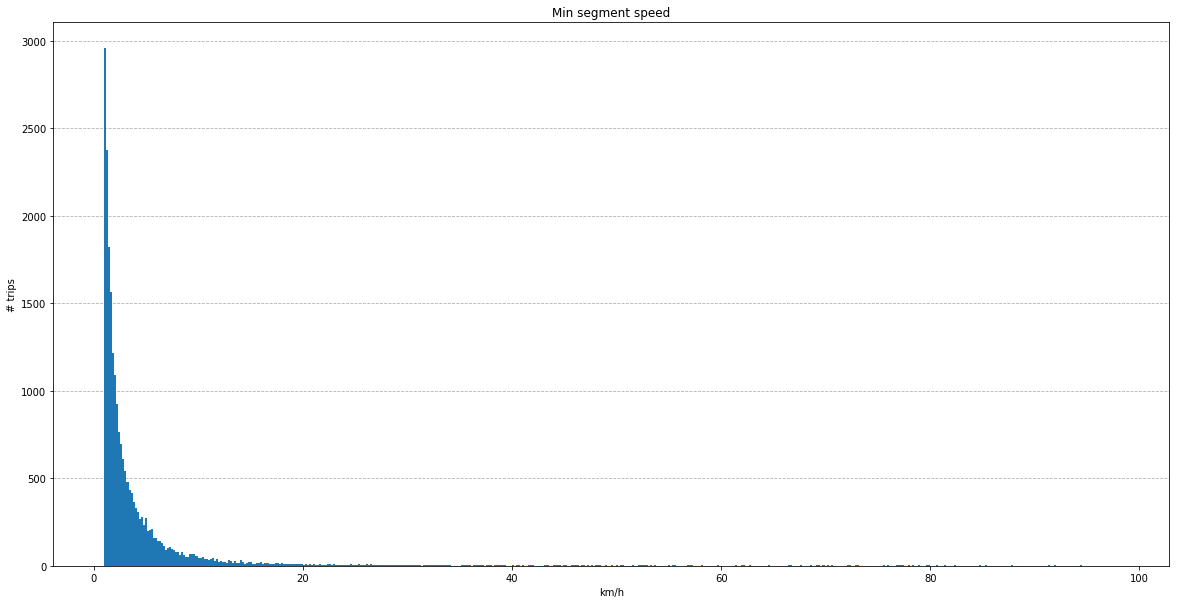

In [26]:
display(trips.min_speed.describe())
selected = trips[(trips.min_speed > 1) & (trips.min_speed < 100)]
plt.figure(figsize=(20, 10))
plots.dist_chart(selected.min_speed, 'Min segment speed', 'km/h')
plt.show()

In [32]:
high_mins = trips[trips.min_speed > 20]
len(high_mins)

1217

In [33]:
high_mins.total_distance.describe()

count    1217.000000
mean      110.390490
std       489.098977
min         0.040959
25%         4.936519
50%        21.979407
75%        68.174099
max      9563.939734
Name: total_distance, dtype: float64

count    296054.000000
mean          0.003818
std           0.091264
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000124
max          19.208217
Name: dist_at_min, dtype: float64

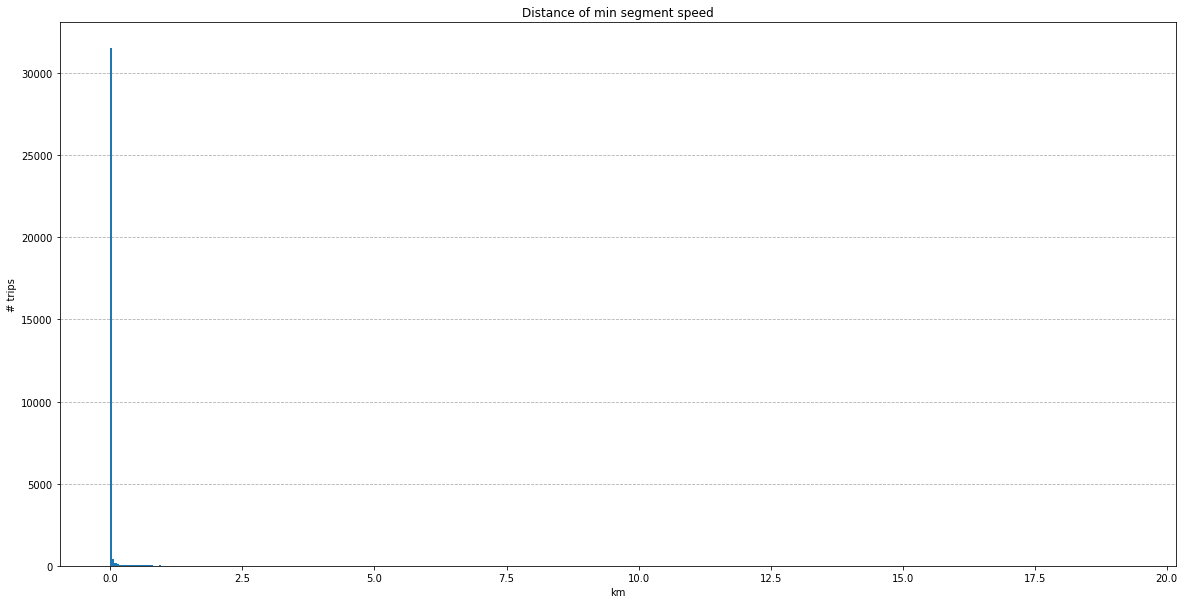

In [22]:
display((trips.dist_at_min/1000).describe())
selected = trips[trips.dist_at_min > 1]
plt.figure(figsize=(20, 10))
plots.dist_chart(selected.dist_at_min/1000, 'Distance of min segment speed', 'km')
plt.show()

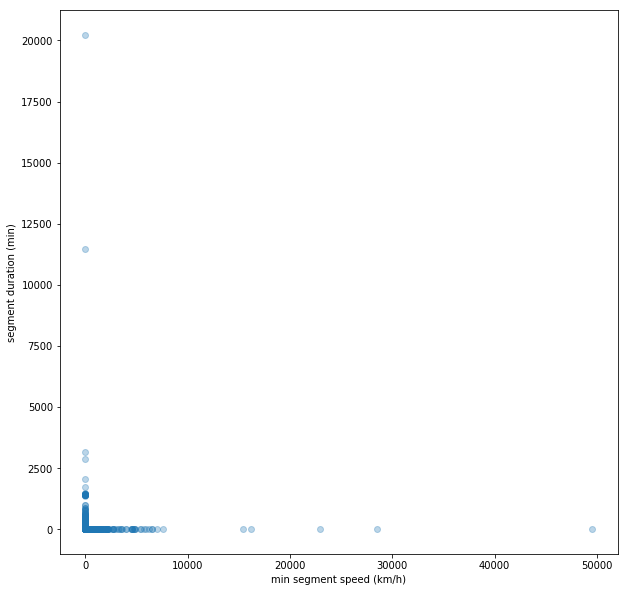

In [27]:
selected = trips#[(trips.min_speed < 2000) & (trips.total_duration < 2000*60)]
plt.figure(figsize=(10, 10))
plt.xlabel('min segment speed (km/h)')
plt.ylabel('segment duration (min)')
plt.scatter(selected.min_speed, selected.dur_at_min/60, alpha=0.3)
plt.show()

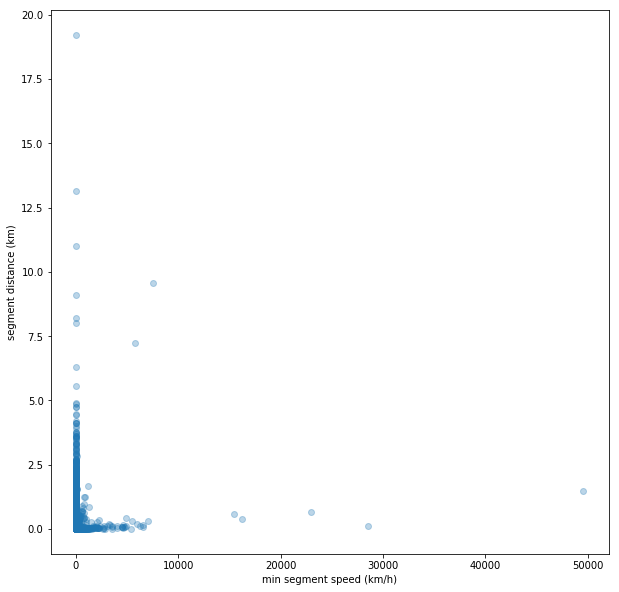

In [28]:
selected = trips#[(trips.min_speed < 2000) & (trips.total_distance < 2000*60)]
plt.figure(figsize=(10, 10))
plt.xlabel('min segment speed (km/h)')
plt.ylabel('segment distance (km)')
plt.scatter(selected.min_speed, selected.dist_at_min/1000, alpha=0.3)
plt.show()

The high minimums

In [ ]:
high_mins = trips[trips.min_speed > 40]
print(len(high_mins), 'trips with high minimum segment speeds')

In [ ]:
high_mins.min_speed.describe()

* **red**: 100+ km/h min speed

In [ ]:
def style_function(trip):
    t = high_mins[high_mins.tripid == trip['properties']['tripid']]
    t = t.loc[t.index[0]]
    return {
        'color': 'blue' if t.min_speed < 100 else 'red'
    }

trajectories = traj.process_trajectories(high_mins)
fmap = traj.create_map([-23.6, -46.7], zoom=11)
folium.GeoJson(trajectories.to_json(), style_function=style_function).add_to(fmap)
fmap

In [ ]:
high_mins['start_time'] = yt.extract_start_times(high_mins)
plt.figure(figsize=(20, 10))
plots.log_scale(y=True)
plots.time_scatter(high_mins.min_speed, 'Trips with high minimum segment speed', 'segment min speed (km)', 
                   high_mins.start_time)
plt.show()

### Max speeds

In [ ]:
trips.max_speed.describe()

In [ ]:
selected = trips[(trips.max_speed > 0) & (trips.max_speed < 200)]
plt.figure(figsize=(20, 10))
plots.dist_chart(selected.max_speed, 'Max segment speed', 'km/h')
plt.show()

The low maximums

In [ ]:
(trips.max_speed//1e-10*1e-10).value_counts().head(10)

* So many zeros...

In [ ]:
zeros = trips[trips.max_speed == 0]
print(len(zeros), 'trips with maximum segment speed of zero')

In [ ]:
zeros.total_distance.describe()

In [ ]:
zeros.total_duration.describe()

In [ ]:
zeros['start_time'] = yt.extract_start_times(zeros)
plt.figure(figsize=(20, 10))
plots.log_scale(y=True)
plots.time_scatter(zeros.total_duration/60, 'Trips with maximum segment speed of zero', 'duration (min)', 
                   zeros.start_time)
plt.show()

* The low maximums

In [ ]:
low_maxs = trips[(trips.max_speed > 0) & (trips.max_speed < 1)]
print(len(low_maxs), 'trips with low maximum segment speeds')

In [ ]:
trajectories = traj.process_trajectories(low_maxs)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

In [ ]:
low_maxs['start_time'] = yt.extract_start_times(low_maxs)
plt.figure(figsize=(20, 10))
plots.log_scale(y=True)
plots.time_scatter(low_maxs.total_duration/60, 'Trips with low maximum segment speeds', 'duration (min)', 
                   low_maxs.start_time)
plt.show()

The high maximums!

In [ ]:
high_maxs = trips[(trips.max_speed > 100)]
print(len(high_maxs), 'trips with high maximum segment speeds')

In [ ]:
trajectories = traj.process_trajectories(high_maxs)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

In [ ]:
(high_maxs.total_distance/1000).describe()

In [ ]:
(high_maxs.total_duration/60).describe()

In [ ]:
selected = high_maxs[high_maxs.total_distance > 100*1000]
print(len(selected), 'trips with high speed and high distances')
trajectories = traj.process_trajectories(selected)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

In [ ]:
selected['start_time'] = yt.extract_start_times(selected)
plt.figure(figsize=(20, 10))
plots.log_scale(y=True)
plots.time_scatter(selected.total_distance/1000, 'Trips with high maximum segment speeds', 'distance (km)', 
                   selected.start_time)
plt.show()

In [ ]:
selected = high_maxs[high_maxs.total_distance < 100*1000]
print(len(selected), 'trips with high speed and low distances')
trajectories = traj.process_trajectories(selected)
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

In [ ]:
selected['start_time'] = yt.extract_start_times(selected)
plt.figure(figsize=(20, 10))
plots.log_scale(y=True)
plots.time_scatter(selected.total_distance/1000, 'Trips with high maximum segment speeds', 'distance (km)', 
                   selected.start_time)
plt.show()